# The ACCESS-NRI Intake Catalog

The [ACCESS-NRI Intake Catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/) was developed by Dougie Squire (ACCESS-NRI).

It is built on top of an existing catalog system called [Intake ESM](https://intake-esm.readthedocs.io/en/stable/), to replicate some of the functionality of the COSIMA Cookbook. 

To quote from the documentation

> The catalog aims to provide a way for Python users to discover and load data across a broad range of climate data products available on the Australian NCI supercomputer Gadi

Because it has similar functionality to the COSIMA Cookbook this is a good opportunity to highlight how they are similar, and also importantly how they differ. It is likely you would benefit from using both in your research, potentially in the same notebook, as they offer complementary capabilities.

The first step is to import the catalog. Because we are using the correct `CLEX` supported `conda` environment, the catalog is available without any extra steps

In [1]:
import intake
import cf_xarray

This is the first obvious difference to the COSIMA Cookbook. There is no connection to a database required, the catalog information is available through an `import`, and can be accessed directly 

In [2]:
catalog = intake.cat.access_nri

## Find the data we want to use

There is no GUI for finding data, but the search API is very powerful and flexible. For example: find every 1 degree ACCESS-OM2 experiment with daily `sea_level` data

In [3]:
variable_name    = "sea_level"
model_name       = "ACCESS-OM2"
experiment_regex = "^1deg.*"
frequency        = "1day"

In [4]:
filtered = catalog.search(model=model_name, name=experiment_regex, variable=variable_name, frequency=frequency)
filtered

,model,description,realm,frequency,variable
name,,,,,
1deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 2/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2_cycle3,{ACCESS-OM2},{Cycle 3/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2_cycle4,{ACCESS-OM2},{Cycle 4/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2_cycle5,{ACCESS-OM2},{Cycle 5/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2_cycle6,{ACCESS-OM2},{Cycle 6/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2spunup_cycle1,{ACCESS-OM2},{Cycle 1/45 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 spunup interannual forcing (1958-2018)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2spunup_cycle2,{ACCESS-OM2},{Cycle 2/45 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 spunup interannual forcing (1958-2018)},{ocean},{1day},{sea_level}
1deg_jra55_iaf_omip2spunup_cycle3,{ACCESS-OM2},{Cycle 3/45 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 spunup interannual forcing (1958-2018)},{ocean},{1day},{sea_level}


Note: 

1. The `name` argument is a regular expression (regex), and does a search for the pattern [see python docs](https://docs.python.org/3/library/re.html#re.search)
2. In this case the other two arguments are straight strings, so only returns exact matches, but they could also be regular expressions

Finding combinations of variables and frequency is not as easy to do with the COSIMA Cookbook

Import a dask client library and start a client to allow parallelisation via dask

In [5]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46881 instead
  warnings.warn(


'/proxy/46881/status'

## Compare to COSIMA Cookbook

Choose the last of the OMIP2 experiments listed in the search above, which is the same data loaded in the sea level notebook using the COSIMA Cookbook. This is to show how accessing data through the two tools differs.

In [6]:
experiment_name = "1deg_jra55_iaf_omip2_cycle6"

Save a variable that points to this experiment

In [7]:
esm_datastore = catalog[experiment_name]

This is an example of where Intake differs from the COSIMA Cookbook. An ESM Datastore can contain multiple datasets, so it is necessary to search *within* an experiment for the variable you already know exists, and then call `.to_dask` to open it as an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). In contrast the COSIMA Cookbookreturns a `DataArray` with just the variable requested: it's hides the detail of the files opened, by design.

In [8]:
%%time
sea_level = esm_datastore.search(variable="sea_level",frequency="1day").to_dask()

CPU times: user 1.69 s, sys: 463 ms, total: 2.15 s
Wall time: 16.7 s


In [9]:
sea_level

<xarray.Dataset>
Dimensions:    (time: 22280, yt_ocean: 300, xt_ocean: 360)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean   (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time       (time) datetime64[ns] 1957-12-30T12:00:00 ... 2018-12-29T12:00:00
Data variables:
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(365, 300, 360), meta=np.ndarray>
Attributes: (12/15)
    filename:                                 ocean_daily.nc
    title:                                    ACCESS-OM2-BGC
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['sea_level']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  sea_surface_temperature,square_...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:filename:                ocean_daily.nc
    intake_esm_attrs:file_id:                 ocean_daily
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_daily.1day

This is exactly the same data as was loaded in the previous notebook (`Sea_level.ipynb`)

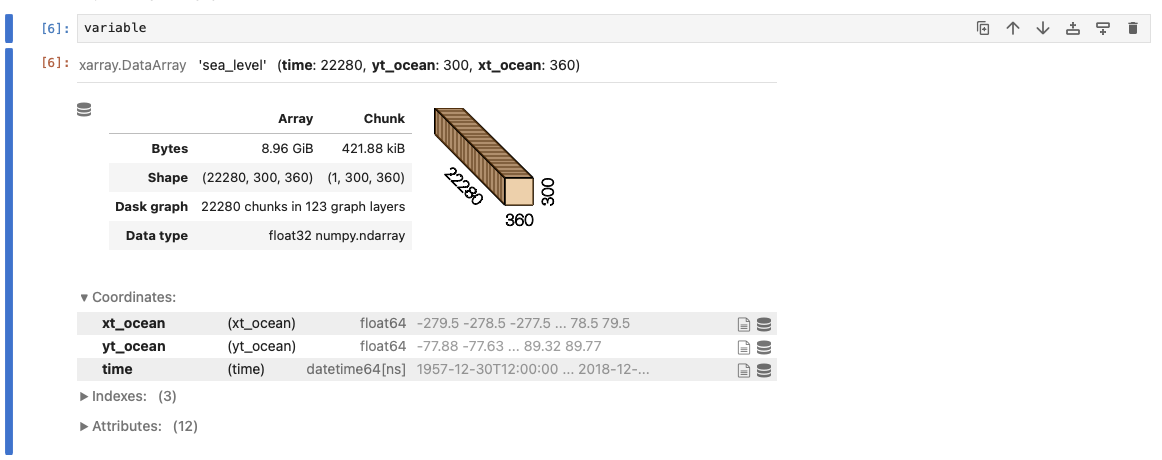

Note there is no way to reduce the number of files that are opened in the process of gathering the metadata to construct the `xarray.Dataset` object. Though the dataset can of course be reduced using `sel`/`isel` before computation or data loading.

## Loading data not available in the Cookbook

The ACCESS-NRI Intake Catalogue indexes approximately 3PB of climate related data on gadi. That is a lot. Far more than is available through the COSIMA Cookbook database. For this reason alone it is useful to use in addition to the COSIMA Cookbook, to access data that would otherwise be difficult, or impossible, to find.

For this example we'll search for the variable `zos` the [sea_surface_height_above_geoid](https://pcmdi.llnl.gov/mips/cmip3/variableList.html#Table_O1c), which is the same as the `sea_level` variable loaded before.

In [10]:
catalog = catalog.search(variable="zos.*")
catalog

,model,description,realm,frequency,variable
name,,,,,
cmip5_al33,"{HadGEM2-ES, NorESM1-ME, MPI-ESM-LR, HadGEM2-CC, CNRM-CM5-2, GFDL-ESM2M, CMCC-CM, MPI-ESM-P, IPSL-CM5A-LR, MRI-CGCM3, CESM1-CAM5, CESM1-BGC, GISS-E2-R-CC, FIO-ESM, EC-EARTH, GFDL-CM2p1, GFDL-ESM2G...",{Replicated CMIP5-era datasets catalogued by NCI},{ocean},{1mon},"{zosga, zos, zostoga, zossga, zossq}"
cmip5_rr3,"{CSIRO-Mk3-6-0, ACCESS1-0, ACCESS1-3}",{Australian CMIP5-era datasets catalogued by NCI},{ocean},{1mon},"{zos, zosga, zostoga, zossga, zossq}"
cmip6_fs38,"{ACCESS-ESM1-5, ACCESS-CM2, ACCESS-OM2-025, ACCESS-OM2}",{Australian CMIP6-era datasets catalogued by NCI},{ocean},{1mon},"{zossq, zostoga, zos}"
cmip6_oi10,"{CESM2, FGOALS-f3-L, EC-Earth3-Veg-LR, NorCPM1, CNRM-CM6-1, TaiESM1-TIMCOM2, CNRM-CM6-1-HR, FGOALS-f3-H, AWI-ESM-1-1-LR, MPI-ESM-1-2-HAM, E3SM-2-0, CMCC-CM2-HR4, IPSL-CM6A-LR, EC-Earth3-CC, HadGEM...",{Replicated CMIP6-era datasets catalogued by NCI},{ocean},{1mon},"{zos, zossq, zostoga}"


So straight away we can see there are a large number of CMIP datasets we could compare our data to, including the ACCESS-OM2 CMIP submissions. 

In this case we'll choose `cmip6_fs38` as it contains some ACCESS coupled models that share the same grid as ACCESS-OM2 1 degree model, allowing easy comparison without regridding.

Note: we're calling this a product. The catalogue is quite flexible, so different products can have quite different structures. The CMIP data has multiple realms, sources and experiments for each product.

In [11]:
product_name = "cmip6_fs38"

In [13]:
esm_datastore = catalog[product_name]

In [14]:
esm_datastore

,unique
path,1039443
file_type,2
realm,7
frequency,10
table_id,24
project_id,1
institution_id,3
source_id,4
experiment_id,52
member_id,80


Ok, here is where the schema-rubber hits the catalog-road. There is no getting around it, you need to understand CMIP land to be able to create a meaningful query for this data source. For fluent speakers of CMIP this is obvious, but this is searching for the historical ACCESS-CM2 experiment, choosing a single ensemble member, selecting the `zos` variable, and asking only for real files rather than symbolic links (that last bit is from the way NCI structure their CMIP collection).

Nonetheless, it works and returns an ACCESS-CM2 dataset with a date-range of 1850 to 2014.

In [17]:
zos_cm2 = esm_datastore.search(source_id="ACCESS-CM2", experiment_id="historical", member_id="r10i1p1f1", variable_id="zos", file_type="f").to_dask()
zos_cm2

<xarray.Dataset>
Dimensions:             (time: 1980, bnds: 2, j: 300, i: 360, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12...
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(1200, 2), meta=np.ndarray>
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    zos                 (time, j, i) float32 dask.array<chunksize=(1200, 300, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            164359.0
    contact:                          access_csiro@csiro.au
    ...                               ...
    intake_esm_attrs:member_id:       r10i1p1f1
    intake_esm_attrs:variable_id:     zos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20220819
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

Can recreate the same climatology as the previous sea level notebook and compare the two. Note here the [cf_xarray accessor](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html) is being used so the CF standard name can be used, which makes this more model agnostic.

In [22]:
zos_cm2_climatology = zos_cm2.sel(time=slice('1957', '1986')).cf['sea_surface_height_above_geoid'].mean(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/cf_xarray/accessor.py:1772: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  warnings.warn(


In [24]:
sea_level_climatology = sea_level.sel(time=slice('1957', '1986')).mean('time').compute()

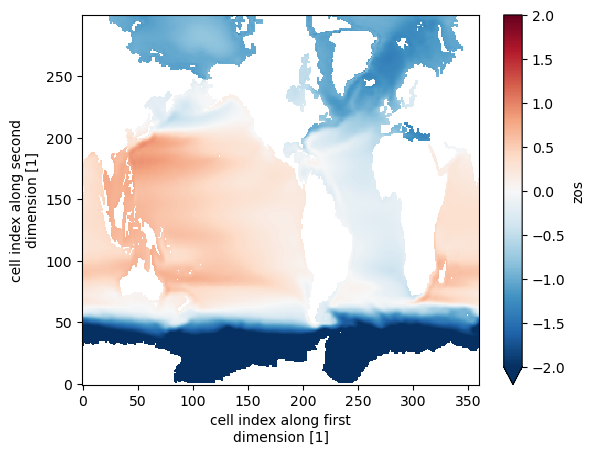

In [34]:
zos_cm2_climatology.plot(vmin=-2, vmax=2, cmap='RdBu_r')

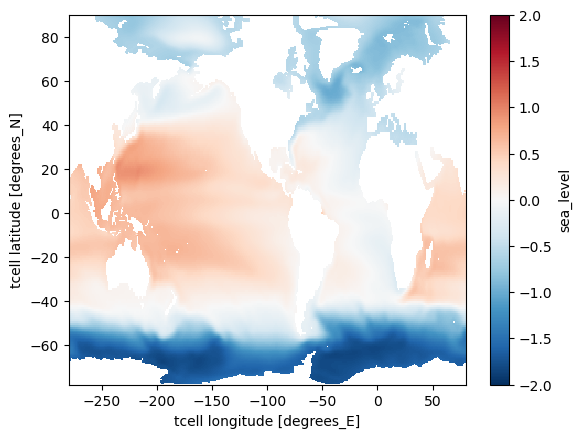

In [35]:
sea_level_climatology.sea_level.plot(vmin=-2, vmax=2, cmap='RdBu_r')

## Appendix

Regarding the use of cf_xarray, just printing the `.cf` accessor provides a wealth of information that the `cf_xarray` library has managed to infer from this data

In [36]:
zos_cm2.cf

Coordinates:
             CF Axes: * X: ['i']
                      * Y: ['j']
                      * T: ['time']
                        Z: n/a

      CF Coordinates:   longitude: ['longitude', 'vertices_longitude']
                        latitude: ['latitude', 'vertices_latitude']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   latitude: ['latitude']
                        longitude: ['longitude']
                      * time: ['time']

              Bounds:   T: ['time_bnds']
                        latitude: ['vertices_latitude']
                        longitude: ['vertices_longitude']
                        time: ['time_bnds']

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   sea_surface_height_above_geoid: ['zos']

              Bounds:   n/a

       Grid Mappings:   n/a